# KS ANALYSIS FOR HDRPLUS Expert


The effect of the image enhancement operator is computed using this function: 

\begin{equation}
L_{\mathrm{out}} = \frac{L_{\mathrm{in}}^{\gamma}}{L_{\mathrm{in}}^{\gamma} + \mu^{\gamma}} 
\end{equation}

See paper for more details

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def assign_cluster_names(df,
                  column_names,
                  red_column_names,
                  name_thr=0.6,
                  add_names_column=True):
    
    df_labels = list(set(df["labels"].values))
    print(df_labels)
    
    cluster_names = []
    cluster_counts = []
    
    for label in df_labels:
        df_cluster = df[df["labels"]==label]
        
        df_cluster_counts = df_cluster[column_names].sum().values / len(df_cluster)
        df_cluster_counts = np.where(df_cluster_counts <= name_thr, df_cluster_counts, 1.0)
        df_cluster_counts = np.where(df_cluster_counts > name_thr, df_cluster_counts, 0.0)
        
        clust_name = ""
        for j, count in enumerate(df_cluster_counts):   
            if count == 1:
                clust_name += red_column_names[j] 
        
        cluster_names.append(clust_name)
        cluster_counts.append(df_cluster_counts)

    print(cluster_names)
        
      
    #cluster_names =  cluster_names[:-1] #+ ["UN"]

    if add_names_column:
        map_label_names = {}
        
        for j, c_name in enumerate(cluster_names):
            if j == len(cluster_names)-1:
                j = -1
            map_label_names[j] = c_name
        
        df["label_name"] = df["labels"].map(map_label_names)

    return cluster_names, cluster_counts

In [3]:
def assign_luminosity_level(df):
    df["luminosity"] = ["0low lum"]*len(df)
    df.loc[df["avg lum"] == 1 , "luminosity"] = "1avg lum"
    df.loc[df["high lum"] == 1 , "luminosity"] = "2high lum"
    return None

In [4]:
def plot_parameter_distribution_per_luminosity(df, param="a", n_bins=50):
    df = df[df["b"] < 1e10]
    df = df[df["a"] < 1e10]
    RD_a_low = df[df["luminosity"]=="0low lum"][param].values
    RD_a_avg = df[df["luminosity"]=="1avg lum"][param].values
    RD_a_high = df[df["luminosity"]=="2high lum"][param].values
    
    plt.hist(RD_a_low, n_bins, weights=np.ones(len(RD_a_low)) / len(RD_a_low), color="r", label="low",alpha=0.3)
    plt.hist(RD_a_avg, n_bins, weights=np.ones(len(RD_a_avg)) / len(RD_a_avg), color="b", label="avg",alpha=0.3)
    plt.hist(RD_a_high, n_bins, weights=np.ones(len(RD_a_high)) / len(RD_a_high), color="g", label="low",alpha=0.3)
    
    plt.legend()
    if param == "a":
        title = r"$\gamma$"
    elif param == "b":
        title = r"$\mu$"
    else:
        title = param
    plt.title(title)

In [5]:
def param_distr_per_feature(df, feature):
    
    features = list(set(df[feature].values))
    a_feature = []
    b_feature = []
    
    for j in features:
        a_feature.append(df[df[feature]==j]["a"].values)
        b_feature.append(df[df[feature]==j]["b"].values)

    return a_feature, b_feature

In [6]:
def ks_test(p_distributions, p_names, plot=True, alpha=0.05, title=None, cbar=False, save_path=''):
    
    p_values = []
    
    for i in range(len(p_distributions)):
        p_value_i = []
        for k in range(len(p_distributions)):
            p_value_ij = stats.ks_2samp(p_distributions[i], p_distributions[k])[1] <= alpha
            p_value_i.append(p_value_ij)
        p_values.append(p_value_i)
        
    if plot:
        mask = np.zeros_like(p_values)
        mask[np.triu_indices_from(mask)] = True
        
        colors = ["red", "green"] 
        cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
        
        ax = sns.heatmap(p_values, mask=mask, linewidth=0.5, xticklabels=p_names, yticklabels=p_names, cmap=cmap, vmin=0.0, vmax=1.0, cbar=cbar)

        if cbar == True:
            colorbar = ax.collections[0].colorbar
            colorbar.set_ticks([0.25,0.75])
            colorbar.set_ticklabels(['False', 'True'])
        
        ax.set_title(title)
        
        if save_path != '':
            plt.savefig(save_path)
            
    return p_values

In [7]:
def plot_a_b_per_group(df, group_name, q_low=0.40, q_high=0.60):
    
    median_fits_values = df[["a", "b", "mse_err", group_name]].groupby(group_name, as_index=False).quantile()
    median_fits_values_low = df[["a", "b", "mse_err", group_name]].groupby(group_name, as_index=False).quantile(q=q_low)
    median_fits_values_high = df[["a", "b", "mse_err", group_name]].groupby(group_name, as_index=False).quantile(q=q_high)
    
    for j in range(len(median_fits_values)):
        
        aerr = (median_fits_values_high.iloc[j]["a"] - median_fits_values_low.iloc[j]["a"])/2.
        berr = (median_fits_values_high.iloc[j]["b"] - median_fits_values_low.iloc[j]["b"])/2.0
        
        plt.errorbar(median_fits_values.iloc[j]["a"],
             median_fits_values.iloc[j]["b"],
             xerr=aerr,
             yerr=berr,
             fmt="o",
             label=median_fits_values.iloc[j][group_name])
        
    plt.xlabel(r"$\gamma$")
    plt.ylabel(r"$\mu$")
    plt.legend()
    plt.show()

In [8]:
clusters_df = pd.read_csv("../data/clusters/hdrplus_train_labels_labels.csv")

In [9]:
print("The percentage of unclassified images is =" , str(np.round(len(clusters_df[clusters_df["labels"]==-1]) / len(clusters_df),3))) 

The percentage of unclassified images is = 0.04


In [10]:
#removing unclustered images 
clusters_df = clusters_df[clusters_df["labels"]!=-1]

In [11]:
clusters_df[["image_name", "labels"]].groupby("labels", as_index=False).count()

labels  image_name
0       0         340
1       1         390
2       2         363
3       3         304
4       4         219

In [12]:
cluster_names, cluster_counts  = assign_cluster_names(clusters_df,
              ['low lum','avg lum','high lum','red','yellow','green','blue','magenta'],
              ["Da", "Av", "Br", "R", "Y", "G", "B", "M"],
              add_names_column=True
             )

[0, 1, 2, 3, 4]
['BrY', 'AvYB', 'DaB', 'DaYB', 'DaY']


In [13]:
hdrplus_df = pd.read_csv("../data/fit_luminance/mit5k_fits_HDRPlus_non_linear1.csv")

In [14]:
hdrplus_df = pd.merge(clusters_df, hdrplus_df,  how="inner", on="image_idx")

In [15]:
assign_luminosity_level(hdrplus_df)

In [16]:
hdrplus_df

image_name_x  image_idx  low lum  \
0     D:/HDRplus_dataset/train/input/0039_20141005_1...          3        0   
1     D:/HDRplus_dataset/train/input/0039_20141005_1...          8        0   
2     D:/HDRplus_dataset/train/input/0039_20141006_1...         19        0   
3     D:/HDRplus_dataset/train/input/0039_20141006_1...         20        0   
4     D:/HDRplus_dataset/train/input/0039_20141006_1...         24        0   
...                                                 ...        ...      ...   
1611  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...       1640        1   
1612  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...       1642        1   
1613  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...       1644        1   
1614  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...       1652        1   
1615  D:/HDRplus_dataset/train/input/JN34_20150327_2...       1677        1   

      avg lum  high lum  red  yellow  green  blue  magenta  labels label_name  \
0           0         1    0       1      0     1        0       0        BrY   
1           0         1    0       1      0     0        0       0        BrY   
2           0         1    0       1      0     1        0       0        BrY   
3           0         1    0       1      0     1        0       0        BrY   
4           0         1    0       1      0     1        0       0        BrY   
...       ...       ...  ...     ...    ...   ...      ...     ...        ...   
1611        0         0    0       0      0     1        0       2        DaB   
1612        0         0    0       0      0     1        0       2        DaB   
1613        0         0    0       0      0     1        0       2        DaB   
1614        0         0    0       0      0     1        0       2        DaB   
1615        0         0    0       0      0     1        1       2        DaB   

                                           image_name_y         a         b  \
0     D:/HDRplus_dataset/train/input/0039_20141005_1...  2.180371  0.492916   
1     D:/HDRplus_dataset/train/input/0039_20141005_1...  1.782209  0.471104   
2     D:/HDRplus_dataset/train/input/0039_20141006_1...  2.401742  0.480185   
3     D:/HDRplus_dataset/train/input/0039_20141006_1...  2.128302  0.490240   
4     D:/HDRplus_dataset/train/input/0039_20141006_1...  2.004134  0.464977   
...                                                 ...       ...       ...   
1611  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...  1.775092  0.319242   
1612  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...  1.967941  0.393955   
1613  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...  2.271451  0.340219   
1614  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...  1.596797  0.434446   
1615  D:/HDRplus_dataset/train/input/JN34_20150327_2...  2.449118  0.398031   

       mse_err luminosity  
0     0.062531  2high lum  
1     0.061776  2high lum  
2     0.036913  2high lum  
3     0.047378  2high lum  
4     0.051888  2high lum  
...        ...        ...  
1611  0.061531   0low lum  
1612  0.063236   0low lum  
1613  0.051510   0low lum  
1614  0.051543   0low lum  
1615  0.014389   0low lum  

[1616 rows x 17 columns]

(0.0, 0.201)

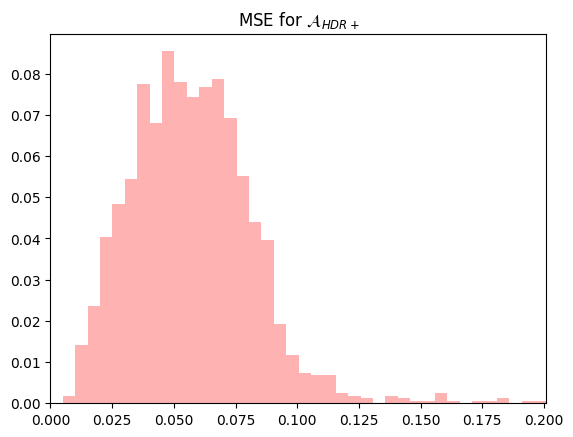

In [17]:
mses = hdrplus_df["mse_err"].values

plt.hist(mses, 50, weights=np.ones(len(mses)) / len(mses), color="r",alpha=0.3)
plt.title(r"MSE for $\mathcal{A}_{HDR+}$")
plt.xlim([0,0.201])


In [18]:
np.median(mses)

0.0558362888221032

In [19]:
len(mses[mses <0.1]) / len(mses)

0.9591584158415841

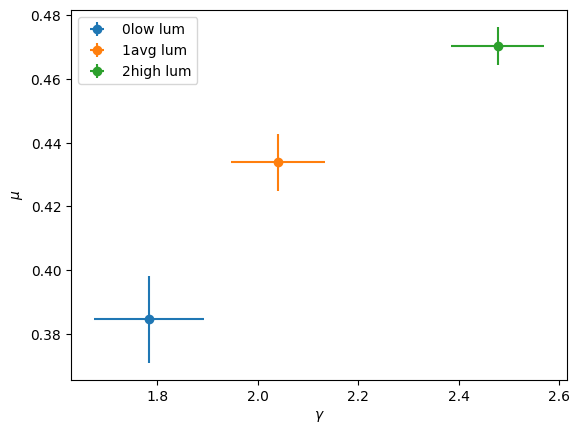

In [20]:
plot_a_b_per_group(hdrplus_df, "luminosity")

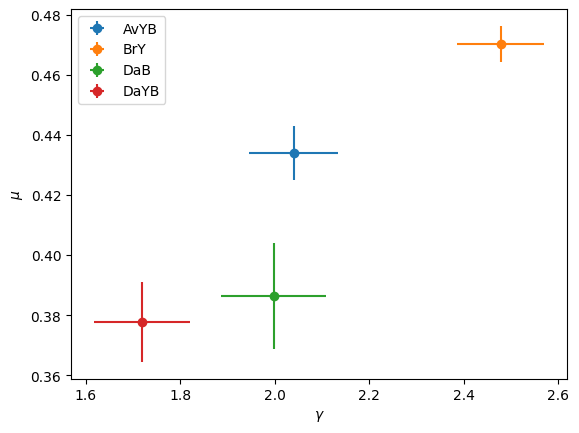

In [21]:
plot_a_b_per_group(hdrplus_df, "label_name")

In [22]:
hdrplus_df

image_name_x  image_idx  low lum  \
0     D:/HDRplus_dataset/train/input/0039_20141005_1...          3        0   
1     D:/HDRplus_dataset/train/input/0039_20141005_1...          8        0   
2     D:/HDRplus_dataset/train/input/0039_20141006_1...         19        0   
3     D:/HDRplus_dataset/train/input/0039_20141006_1...         20        0   
4     D:/HDRplus_dataset/train/input/0039_20141006_1...         24        0   
...                                                 ...        ...      ...   
1611  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...       1640        1   
1612  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...       1642        1   
1613  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...       1644        1   
1614  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...       1652        1   
1615  D:/HDRplus_dataset/train/input/JN34_20150327_2...       1677        1   

      avg lum  high lum  red  yellow  green  blue  magenta  labels label_name  \
0           0         1    0       1      0     1        0       0        BrY   
1           0         1    0       1      0     0        0       0        BrY   
2           0         1    0       1      0     1        0       0        BrY   
3           0         1    0       1      0     1        0       0        BrY   
4           0         1    0       1      0     1        0       0        BrY   
...       ...       ...  ...     ...    ...   ...      ...     ...        ...   
1611        0         0    0       0      0     1        0       2        DaB   
1612        0         0    0       0      0     1        0       2        DaB   
1613        0         0    0       0      0     1        0       2        DaB   
1614        0         0    0       0      0     1        0       2        DaB   
1615        0         0    0       0      0     1        1       2        DaB   

                                           image_name_y         a         b  \
0     D:/HDRplus_dataset/train/input/0039_20141005_1...  2.180371  0.492916   
1     D:/HDRplus_dataset/train/input/0039_20141005_1...  1.782209  0.471104   
2     D:/HDRplus_dataset/train/input/0039_20141006_1...  2.401742  0.480185   
3     D:/HDRplus_dataset/train/input/0039_20141006_1...  2.128302  0.490240   
4     D:/HDRplus_dataset/train/input/0039_20141006_1...  2.004134  0.464977   
...                                                 ...       ...       ...   
1611  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...  1.775092  0.319242   
1612  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...  1.967941  0.393955   
1613  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...  2.271451  0.340219   
1614  D:/HDRplus_dataset/train/input/J6ZC_20150408_1...  1.596797  0.434446   
1615  D:/HDRplus_dataset/train/input/JN34_20150327_2...  2.449118  0.398031   

       mse_err luminosity  
0     0.062531  2high lum  
1     0.061776  2high lum  
2     0.036913  2high lum  
3     0.047378  2high lum  
4     0.051888  2high lum  
...        ...        ...  
1611  0.061531   0low lum  
1612  0.063236   0low lum  
1613  0.051510   0low lum  
1614  0.051543   0low lum  
1615  0.014389   0low lum  

[1616 rows x 17 columns]

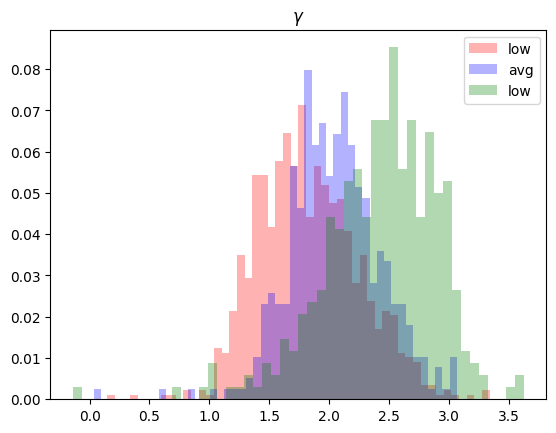

In [23]:
plot_parameter_distribution_per_luminosity(hdrplus_df, "a")

In [24]:
hdrplus_df[hdrplus_df["b"] > 1e150]

image_name_x  image_idx  low lum  \
670  D:/HDRplus_dataset/train/input/6G7M_20150321_1...       1343        0   

     avg lum  high lum  red  yellow  green  blue  magenta  labels label_name  \
670        1         0    0       0      1     1        0       1       AvYB   

                                          image_name_y         a  \
670  D:/HDRplus_dataset/train/input/6G7M_20150321_1...  0.001013   

                 b   mse_err luminosity  
670  6.091860e+158  0.185109   1avg lum

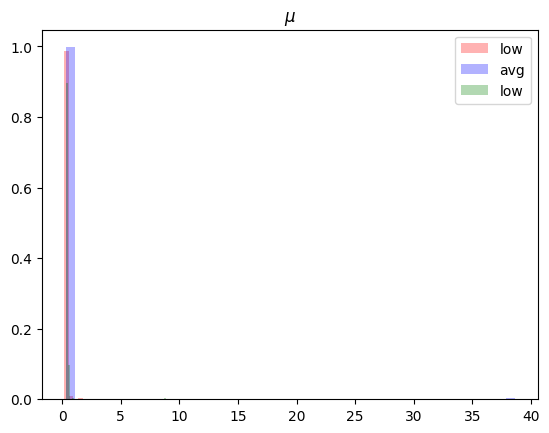

In [25]:
plot_parameter_distribution_per_luminosity(hdrplus_df, "b", n_bins=50)

In [26]:
[a_lum, b_lum] = param_distr_per_feature(hdrplus_df, "luminosity")

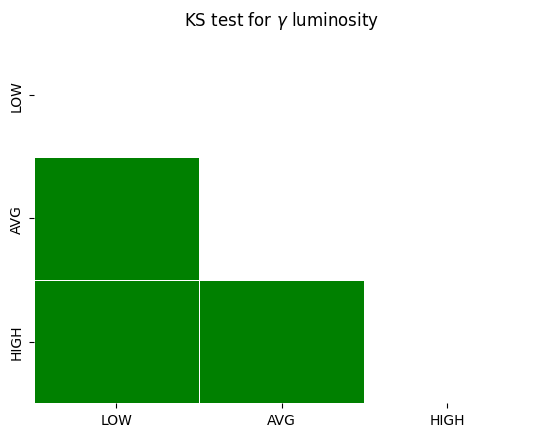

In [27]:
p_values_a_lum = ks_test(a_lum, ["LOW", "AVG", "HIGH"], plot=True, alpha=0.05, title=r"KS test for $\gamma$ luminosity")

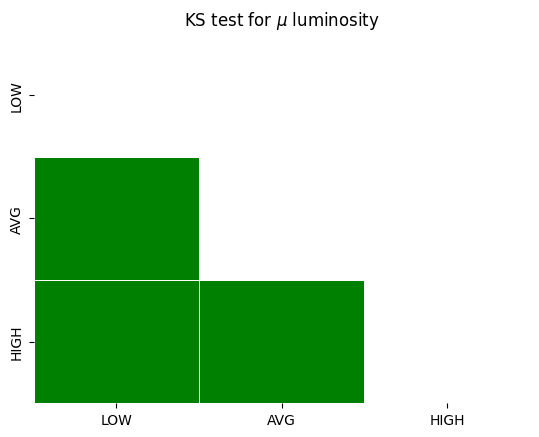

In [28]:
p_values_a_lum = ks_test(b_lum, ["LOW", "AVG", "HIGH"], plot=True, alpha=0.05, title=r"KS test for $\mu$ luminosity")

REMINDER:
- **TRUE: p-values is smaller than 0.05**, so we reject the null hypothesis in favor of the default “two-sided” alternative: the data were not drawn from the same distribution.
- **FALSE: p-values is higher than 0.05**, so we cannot reject the null hypothesis in favor of the default “two-sided” alternative: the data were drawn from the same distribution.

For HDRplus the groups with different **luminosity** are treated different since both $\mu$ is different from different luminosity.

In [29]:
[a_cluster, b_cluster] = param_distr_per_feature(hdrplus_df, "labels")

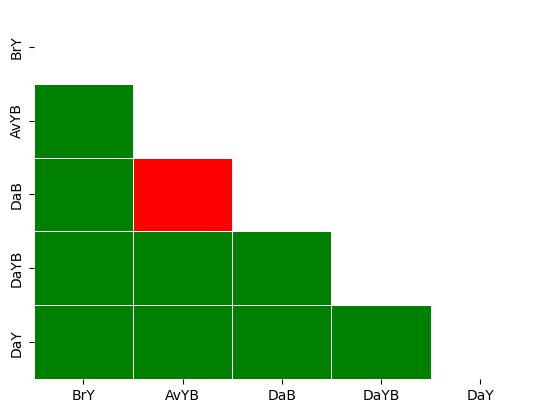

In [30]:
p_values_a_cluster = ks_test(a_cluster, cluster_names, plot=True, alpha=0.05)

HDRplus seems to **treat differently images with same luminosity if the have different colors! for $\gamma$** 

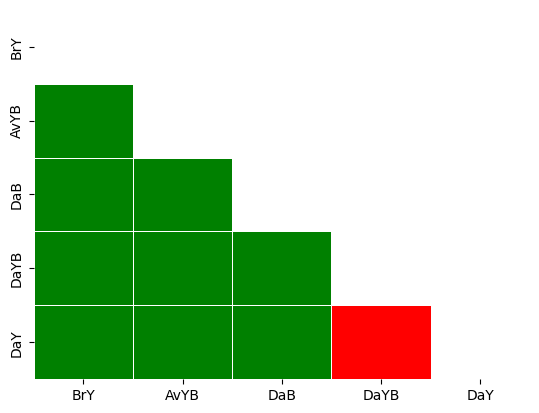

In [31]:
p_values_b_cluster = ks_test(b_cluster, cluster_names, plot=True, alpha=0.05)

HDRplus seems to **treat differently images with same luminosity if the have different colors! for $\mu$** 

Text(0.5, 1.0, 'b')

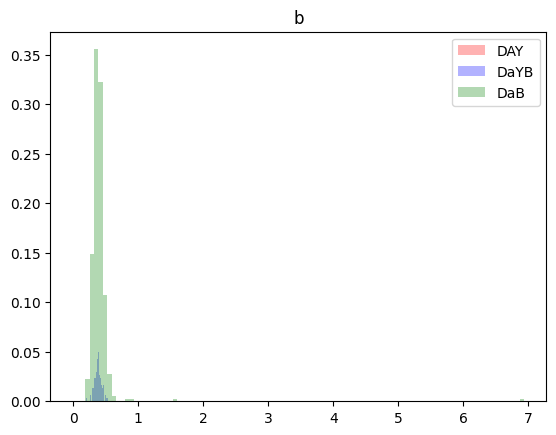

In [32]:
n_bins= 100
param = "b"

RD_a_DaY = hdrplus_df[hdrplus_df["label_name"]=="DaY"][param].values
RD_a_DaY = RD_a_DaY[RD_a_DaY <= 10]
RD_a_DaYB = hdrplus_df[hdrplus_df["label_name"]=="DaYB"][param].values
RD_a_DaYB = RD_a_DaYB[RD_a_DaYB <= 10]
RD_a_DaB = hdrplus_df[hdrplus_df["label_name"]=="DaB"][param].values
RD_a_DaB = RD_a_DaB[RD_a_DaB <= 10]

plt.hist(RD_a_DaY, n_bins, weights=np.ones(len(RD_a_DaY)) / len(RD_a_DaY), color="r", label="DAY",alpha=0.3)
plt.hist(RD_a_DaYB, n_bins, weights=np.ones(len(RD_a_DaYB)) / len(RD_a_DaYB), color="b", label="DaYB",alpha=0.3)
plt.hist(RD_a_DaB, n_bins, weights=np.ones(len(RD_a_DaB)) / len(RD_a_DaB), color="g", label="DaB",alpha=0.3)
    
plt.legend()
plt.title(param)

Text(0.5, 1.0, 'a')

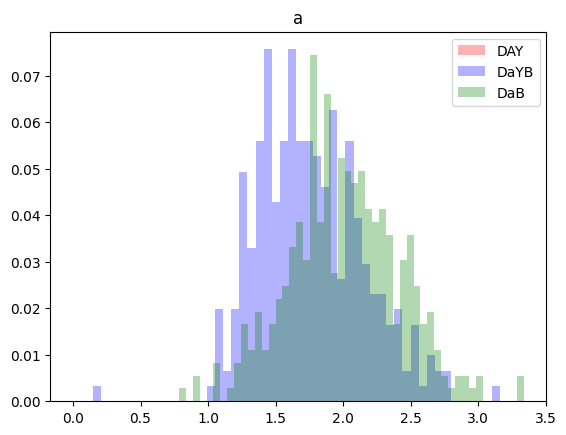

In [33]:
n_bins= 50
param = "a"

RD_a_DaY = hdrplus_df[hdrplus_df["label_name"]=="DaY"][param].values
RD_a_DaY = RD_a_DaY[RD_a_DaY <= 10]
RD_a_DaYB = hdrplus_df[hdrplus_df["label_name"]=="DaYB"][param].values
RD_a_DaYB = RD_a_DaYB[RD_a_DaYB <= 10]
RD_a_DaB = hdrplus_df[hdrplus_df["label_name"]=="DaB"][param].values
RD_a_DaB = RD_a_DaB[RD_a_DaB <= 10]

plt.hist(RD_a_DaY, n_bins, weights=np.ones(len(RD_a_DaY)) / len(RD_a_DaY), color="r", label="DAY",alpha=0.3)
plt.hist(RD_a_DaYB, n_bins, weights=np.ones(len(RD_a_DaYB)) / len(RD_a_DaYB), color="b", label="DaYB",alpha=0.3)
plt.hist(RD_a_DaB, n_bins, weights=np.ones(len(RD_a_DaB)) / len(RD_a_DaB), color="g", label="DaB",alpha=0.3)
    
plt.legend()
plt.title(param)